In [21]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from tensorboardX import SummaryWriter

from sklearn.metrics import confusion_matrix
from resources.plots import *
import pickle

## Constants definitions

In [2]:
PATH = "../datasets/yeast_v4"
data_path = Path(PATH)

In [3]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200
NAME = "Res_Net_34_Batch_Eq"
RESULTS = './results/'

## TensorBoard setup

In [4]:
if not os.path.isdir(RESULTS): os.makedirs(RESULTS)

In [5]:
writer = SummaryWriter(RESULTS+NAME)

In [6]:
stats_name = "yeast_v4_per_class.dict"
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs,save_name=stats_name)

working on: mfb1KO
working on: mfb1KO_mmr1KO
working on: mmr1KO
working on: WT


In [7]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs,balance=True)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [8]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_dict)

-0.006970908076958817
-0.003947202223064285
0.14443836282916744
-0.046832720460695205

 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmr1KO': 3}


In [9]:
x, y = next(iter(data.trn_dl))

In [10]:
print(y.size())

torch.Size([64])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


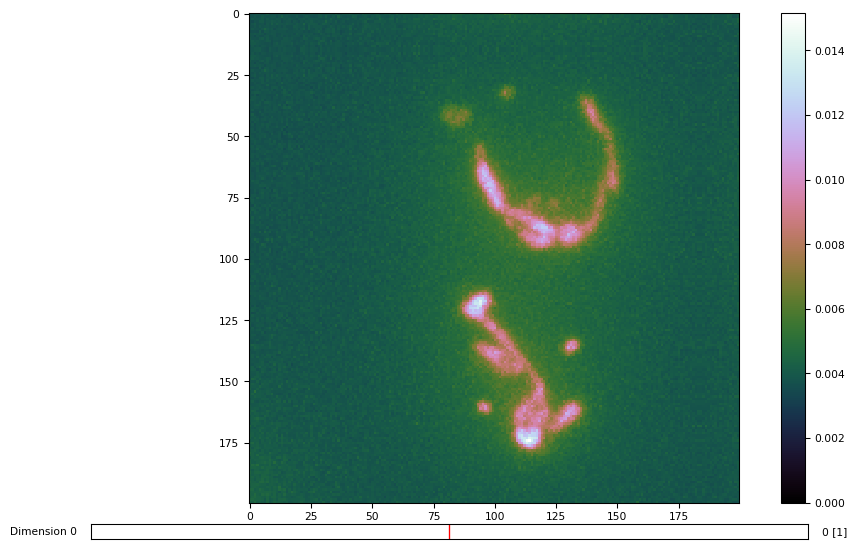

In [11]:
idx = 0
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx]).squeeze()[:,:,1]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

In [12]:
torch.cuda.is_available()

True

## ResNet_with_Batchnorm

In [13]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [14]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [15]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [16]:
model = Resnet([10, 20, 40, 80, 160], NUM_CLASSES)
model.writer = writer
model.name = NAME

In [17]:
learn = ConvLearner.from_model_data(model, data)

In [18]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
     

In [19]:
wd=1e-5

In [20]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

[0]:  1.0%                                                
[1]:  0.0%
[2]:  0.0%
[3]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      33.947953  20.283186  0.285714  
[0]:  0.0%                                               
[1]:  0.0%
[2]:  0.0%
[3]:  1.0%
    1      20.951873  5.936956   0.228571  
[0]: 0.6333%                                              
[1]: 0.3462%
[2]:  0.0%
[3]:  0.0%
    2      13.883566  2.192685   0.295238  
[0]:  1.0%                                                
[1]:  0.0%
[2]:  0.0%
[3]:  0.0%
    3      9.988622   1.93139    0.285714  
[0]:  0.0%                                                
[1]:  0.0%
[2]:  0.0%
[3]:  1.0%
    4      8.650332   5.812728   0.228571  
[0]:  1.0%                                                
[1]:  0.0%
[2]:  0.0%
[3]:  0.0%
    5      7.138133   2.196865   0.285714  
[0]:  0.0%                                                
[1]: 0.2692%
[2]:  0.6%
[3]: 0.3333%
    6      5.827932   1.545317   0.285714 

[array([1.12864]), 0.41904762131827217]

In [ ]:
# at very little overfitting we have 43% accuracy
%time learn.fit(1e-2, 8, wds=wd, cycle_len=4, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

[[19  3  7  5]                               
 [ 4 15  3  5]
 [ 7  3 13  6]
 [ 0  5  2  8]]


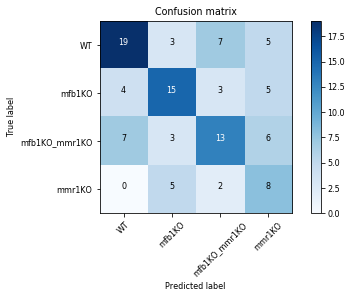

In [31]:
log_preds, y = learn.TTA()
preds = np.argmax(log_preds[1], axis=1)
cm = confusion_matrix(preds,y)

with open(RESULTS+NAME+"_metrics"+'/cm/confusion_matrix.32.array','wb') as file:
    pickle.dump(cm,file)
    
plot_confusion_matrix(cm, data.classes)

In [32]:
%time learn.fit(1e-4, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

[0]:  0.9%                                                
[1]: 0.5385%
[2]: 0.04%
[3]: 0.1667%
epoch      trn_loss   val_loss   accuracy   
    0      1.081283   1.338969   0.447619  
[0]: 0.06667%                                             
[1]: 0.1538%
[2]:  0.0%
[3]: 0.8333%
    1      1.276667   1.57541    0.247619  
[0]: 0.03333%                                            
[1]: 0.07692%
[2]:  0.8%
[3]: 0.4583%
    2      1.403051   1.455802   0.333333  
[0]: 0.9333%                                              
[1]: 0.03846%
[2]:  0.0%
[3]: 0.08333%
    3      1.443429   1.829965   0.314286  
[0]: 0.1333%                                              
[1]: 0.1154%
[2]:  0.0%
[3]: 0.875%
    4      1.466709   1.784748   0.27619   
[0]: 0.4667%                                              
[1]: 0.1923%
[2]:  0.0%
[3]: 0.7083%
    5      1.485034   1.434876   0.4       
[0]: 0.4333%                                              
[1]: 0.3077%
[2]: 0.32%
[3]: 0.3333%
    6      1.44311

[0]:  0.8%                                                 
[1]: 0.7692%
[2]: 0.16%
[3]: 0.6667%
    58     0.698262   0.869666   0.619048  
[0]: 0.7667%                                               
[1]: 0.6538%
[2]:  0.0%
[3]: 0.7917%
    59     0.684028   1.132859   0.609524  
[0]:  0.8%                                                 
[1]: 0.8846%
[2]:  0.2%
[3]: 0.4167%
    60     0.686432   1.036818   0.590476  
[0]:  0.9%                                                 
[1]:  0.5%
[2]: 0.32%
[3]: 0.5833%
    61     0.684201   0.955189   0.609524  
[0]: 0.7333%                                               
[1]: 0.6154%
[2]: 0.68%
[3]: 0.625%
    62     0.688704   0.696051   0.714286  
[0]: 0.6333%                                               
[1]: 0.7308%
[2]: 0.72%
[3]: 0.375%
    63     0.684095   0.73443    0.67619   
[0]:  0.5%                                                 
[1]: 0.6923%
[2]: 0.64%
[3]: 0.7083%
    64     0.681888   0.798759   0.695238  
[0]: 0.5667%     

[0]: 0.8667%                                               
[1]: 0.7308%
[2]: 0.48%
[3]: 0.5417%
   116     0.370543   0.917689   0.695238  
[0]: 0.8333%                                               
[1]: 0.6923%
[2]:  0.2%
[3]: 0.7083%
   117     0.357708   0.972565   0.657143  
[0]: 0.7667%                                               
[1]: 0.7692%
[2]:  0.6%
[3]:  0.5%
   118     0.335377   0.813122   0.695238  
[0]: 0.8333%                                               
[1]: 0.6154%
[2]:  0.2%
[3]: 0.8333%
   119     0.314456   0.939692   0.67619   
[0]: 0.7333%                                               
[1]: 0.6538%
[2]: 0.52%
[3]: 0.5417%
   120     0.303957   0.849879   0.685714  
[0]:  0.9%                                                
[1]: 0.7308%
[2]:  0.4%
[3]: 0.5833%
   121     0.299682   0.886139   0.67619   
[0]:  0.8%                                                 
[1]: 0.6923%
[2]:  0.4%
[3]: 0.75%
   122     0.306212   0.950801   0.733333  
[0]:  0.7%        

[0]: 0.8333%                                               
[1]: 0.5385%
[2]:  0.2%
[3]: 0.75%
   174     0.348614   1.164584   0.666667  
[0]:  0.9%                                                 
[1]: 0.6538%
[2]: 0.36%
[3]: 0.7083%
   175     0.334971   0.985907   0.714286  
[0]:  0.9%                                                 
[1]: 0.6154%
[2]: 0.24%
[3]: 0.625%
   176     0.314652   1.285698   0.67619   
[0]: 0.8667%                                               
[1]: 0.6154%
[2]: 0.56%
[3]: 0.5417%
   177     0.313519   1.034601   0.704762  
[0]:  0.9%                                                 
[1]: 0.7692%
[2]: 0.44%
[3]:  0.5%
   178     0.3079     1.102058   0.695238  
[0]:  0.9%                                                 
[1]: 0.8077%
[2]:  0.2%
[3]: 0.5417%
   179     0.339138   1.304075   0.647619  
[0]: 0.8667%                                               
[1]: 0.7692%
[2]: 0.44%
[3]: 0.625%
   180     0.364802   1.11289    0.733333  
[0]: 0.8667%       

KeyboardInterrupt: 

[[23  1  2  1]                               
 [ 3 22  5  3]
 [ 4  3 15  7]
 [ 0  0  3 13]]


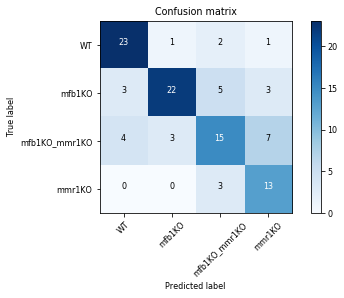

In [33]:
log_preds, y = learn.TTA()
preds = np.argmax(log_preds[1], axis=1)
cm = confusion_matrix(preds,y)

with open(RESULTS+NAME+"_metrics"+'/cm/confusion_matrix.352.array','wb') as file:
    pickle.dump(cm,file)
    
plot_confusion_matrix(cm, data.classes)

In [34]:
learn.save(NAME)